In [1]:
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Reshape, Flatten, Activation, Dense, concatenate
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.advanced_activations import ReLU, LeakyReLU
from keras.optimizers import Adam, RMSprop
from keras.utils import multi_gpu_model

import keras
import keras.backend as K
import keras.backend.tensorflow_backend as KTF
import tensorflow as tf

import shutil, os, sys, io, random, math
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
from PIL import Image
from tqdm import tqdm

os.chdir('/home/k_yonhon/py/Keras-GAN/toymodel/')
sys.path.append(os.pardir)

from tensor_board_logger import TensorBoardLogger
from wasserstein_loss import WassersteinLoss, GradientPenaltyLoss, CramerGradientPenaltyLoss, L2Norm

config = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True))
session = tf.Session(config=config)
KTF.set_session(session)

# ---------------------
#  Parameter
# ---------------------
gpu_count = 1

Using TensorFlow backend.


In [2]:
from collections import OrderedDict
from tensorflow.contrib import graph_editor
import tensorflow_probability as tfp
ds = tfp.distributions
slim = tf.contrib.slim
generate_movie = False

def sample_mog(batch_size, n_mixture=8, std=0.01, radius=1.0):
    thetas = np.linspace(0, 2 * np.pi, n_mixture)
    xs, ys = radius * np.sin(thetas), radius * np.cos(thetas)
    cat = ds.Categorical(tf.zeros(n_mixture))
    comps = [ds.MultivariateNormalDiag([xi, yi], [std, std]) for xi, yi in zip(xs.ravel(), ys.ravel())]
    # MultivariateNormalDiag呼び出しでエラー。ただし現状numpy内部でnp.asscalar(a)をa.item()にswapしており実害なし。
    data = ds.Mixture(cat, comps)
    return data.sample(batch_size)
    # 半径1の円周上8点を中心とした8個の正規分布からbatch_size個の点をサンプリング

In [3]:
class CRAMER_GAN():
    def __init__(self, gpu_count=1):
        # ---------------------
        #  Parameter
        # ---------------------
        # self.dataset = dataset
        self.gpu_count = gpu_count
        
        '''
        self.img_rows = dataset.shape[1]
        self.img_cols = dataset.shape[2]
        self.channels = dataset.shape[3]
        self.img_shape = (self.img_rows, self.img_cols, self.channels)

        self.input_rows = 4
        self.input_cols = 4
        self.latent_dim = 128  # Noise dim
        '''

        self.img_dim = 2
        self.img_shape = (self.img_dim, )
        self.latent_dim = 256
        
        self.n_critic = 5
        self.λ = 10        
        # optimizer_disc = RMSprop(lr=0.00005)
        # optimizer_gen = RMSprop(lr=0.0005)
        optimizer_disc = Adam(lr=0.0001, beta_1=0., beta_2=0.9, epsilon=None, decay=0.0, amsgrad=False)
        optimizer_gen = Adam(lr=0.0001, beta_1=0., beta_2=0.9, epsilon=None, decay=0.0, amsgrad=False)
        
        # ---------------------
        #  for TensorBoard
        # ---------------------
        target_dir = "./my_log_dir"
        shutil.rmtree(target_dir, ignore_errors=True)
        os.mkdir(target_dir)
        self.logger = TensorBoardLogger(log_dir=target_dir)

        # ---------------------
        #  Load models
        # ---------------------
        self.critic = self.build_critic()
        self.generator = self.build_generator()
        
        #-------------------------------
        # Compile Critic
        #-------------------------------    
        generated_samples_1 = Input(shape=self.img_shape) 
        critic_output_from_generated_samples_1 = self.critic(generated_samples_1)
        
        generated_samples_2 = Input(shape=self.img_shape) 
        critic_output_from_generated_samples_2 = self.critic(generated_samples_2)
        
        real_samples = Input(shape=self.img_shape)        
        critic_output_from_real_samples = self.critic(real_samples)

        averaged_samples = Input(shape=self.img_shape)
        critic_output_from_averaged_samples = self.critic(averaged_samples)

        term_11 = keras.layers.subtract([critic_output_from_real_samples, critic_output_from_generated_samples_2])
        term_12 = critic_output_from_real_samples

        term_21 = keras.layers.subtract([critic_output_from_generated_samples_1, critic_output_from_generated_samples_2])
        term_22 = critic_output_from_generated_samples_1
        
        term_31 = keras.layers.subtract([critic_output_from_averaged_samples, critic_output_from_generated_samples_2])
        term_32 = critic_output_from_averaged_samples
        
        partial_gp_loss = partial(CramerGradientPenaltyLoss,
                                  y_pred_2 = term_32,
                                  averaged_samples=averaged_samples,
                                  gradient_penalty_weight=self.λ)
        # Functions need names or Keras will throw an error
        partial_gp_loss.__name__ = 'gradient_penalty'

        self.critic_model = Model(inputs=[generated_samples_1, 
                                          generated_samples_2, 
                                          real_samples,
                                          averaged_samples],
                                  outputs=[term_11, 
                                           term_12, 
                                           term_21, 
                                           term_22,
                                           term_31])
        if self.gpu_count > 1:
            self.critic_model = multi_gpu_model(self.critic_model, gpus=self.gpu_count)
        self.critic_model.compile(optimizer=optimizer_disc, 
                                  loss=[L2Norm, 
                                        L2Norm, 
                                        L2Norm, 
                                        L2Norm, 
                                        partial_gp_loss])
        
        print('Critic Summary:')
        self.critic.summary()       

        #-------------------------------
        # Compile Generator
        #-------------------------------
        # For the generator we freeze the critic's layers
        self.critic.trainable = False
                    
        generator_input_1 = Input(shape=(self.latent_dim,))
        generator_layers_1 = self.generator(generator_input_1)
        critic_layers_for_generator_1 = self.critic(generator_layers_1)
        
        generator_input_2 = Input(shape=(self.latent_dim,))
        generator_layers_2 = self.generator(generator_input_2)
        critic_layers_for_generator_2 = self.critic(generator_layers_2)
        # generated_samples_2 = Input(shape=self.img_shape) 
        # critic_output_from_generated_samples_2 = self.critic(generated_samples_2)

        real_samples = Input(shape=self.img_shape)        
        critic_output_from_real_samples = self.critic(real_samples)
        
        term_41 = keras.layers.subtract([critic_output_from_real_samples, critic_layers_for_generator_2])
        term_42 = critic_output_from_real_samples
        term_51 = keras.layers.subtract([critic_layers_for_generator_1, critic_layers_for_generator_2])
        term_52 = critic_layers_for_generator_1
        
        self.generator_model = Model(inputs=[generator_input_1, 
                                             generator_input_2, 
                                             real_samples], 
                                     outputs=[term_41, 
                                              term_42, 
                                              term_51, 
                                              term_52])
        if self.gpu_count > 1:
            self.generator_model = multi_gpu_model(self.generator_model, gpus=self.gpu_count)
        self.generator_model.compile(optimizer=optimizer_gen,
                                     loss=[L2Norm,
                                           L2Norm,
                                           L2Norm,
                                           L2Norm])        

        print('Genarator Summary:')
        self.generator.summary()   

    def build_generator(self):
        model = Sequential()
        model.add(Dense(128,
                        kernel_initializer=keras.initializers.Orthogonal(gain=1.4, seed=None),
                        activation='tanh'))
        model.add(Dense(128,
                        kernel_initializer=keras.initializers.Orthogonal(gain=1.4, seed=None),
                        activation='tanh'))
        model.add(Dense(2,
                        kernel_initializer=keras.initializers.Orthogonal(gain=1.4, seed=None),
                       ))
        # model.summary()
        noise = Input(shape=(self.latent_dim,))
        img = model(noise)
        return Model(noise, img)
    
    def build_critic(self):
        model = Sequential()
        # model.add(Flatten(input_shape=self.img_shape))
        model.add(Dense(128,
                        kernel_initializer=keras.initializers.Orthogonal(gain=1.4, seed=None),
                        activation='tanh'))
        model.add(Dense(128,
                        kernel_initializer=keras.initializers.Orthogonal(gain=1.4, seed=None),
                        activation='tanh'))
        model.add(Dense(128,
                        kernel_initializer=keras.initializers.Orthogonal(gain=1.4, seed=None),
                       ))
        # model.summary()
        img = Input(shape=(self.img_dim,))
        validity = model(img)
        return Model(img, validity)
    
    def train(self, epochs, batch_size, sample_interval=5000, resume=0):
        frames = []
        np_samples = []
        X_train = tf.Session().run(sample_mog(60000))

        # Adversarial ground truths
        minus = -np.ones((batch_size, 1), dtype=np.float32)
        plus = np.ones((batch_size, 1), dtype=np.float32)
        zero = np.zeros((batch_size, 1), dtype=np.float32)

        # ---------------------
        #  Training
        # ---------------------
        for epoch in tqdm(range(resume, resume + epochs + 1)):
        
            # Log generated image samples
            if epoch % sample_interval == 0:
                idx = np.random.randint(0, X_train.shape[0], batch_size)
                imgs = X_train[idx]  
                noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
                gen_imgs = self.generator.predict(noise)
                np_samples.append(np.vstack(gen_imgs)) # 縦方向(vertical)に連結
                xx = gen_imgs
                yy = imgs
                fig = figure(figsize=(5,5))
                scatter(xx[:, 0], xx[:, 1], edgecolor='none')
                scatter(yy[:, 0], yy[:, 1], c='g')
                axis('off')
                if generate_movie:
                    frames.append(mplfig_to_npimage(fig))
                show()
            
            for _ in range(self.n_critic):
                idx = np.random.randint(0, X_train.shape[0], batch_size)
                imgs = X_train[idx]              
                
                noise_1 = np.random.normal(0, 1, (batch_size, self.latent_dim))
                gen_imgs_1 = self.generator.predict(noise_1, batch_size=batch_size)
                noise_2 = np.random.normal(0, 1, (batch_size, self.latent_dim))
                gen_imgs_2 = self.generator.predict(noise_2, batch_size=batch_size)
                
                idx = np.random.randint(0, X_train.shape[0], batch_size)
                real_imgs = X_train[idx]
                               
                ε = np.random.uniform(size=(batch_size,1))
                ave_imgs = ε * real_imgs + (1-ε) * gen_imgs_1
                
                # Train Critic
                d_loss = self.critic_model.train_on_batch([gen_imgs_1, gen_imgs_2, real_imgs, ave_imgs], 
                                                          [minus, plus, plus, minus, zero])

            # Train Generator
            noise_1 = np.random.normal(0, 1, (batch_size, self.latent_dim))
            noise_2 = np.random.normal(0, 1, (batch_size, self.latent_dim))
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            real_imgs = X_train[idx]
            g_loss = self.generator_model.train_on_batch([noise_1, noise_2, real_imgs], 
                                                         [plus, minus, minus, plus])

            # ---------------------
            #  Logging
            # ---------------------
            '''
            # Backup Model
            if epoch != resume and epoch % sample_interval == 0:
            # if epoch != resume and (epoch % 1000 == 0 or epoch % sample_interval == 0):
                self.critic.save('./saved_model/wgangp_dc'+str(self.img_rows)+'_critic_model_'+str(epoch)+'epoch.h5')
                self.generator.save('./saved_model/wgangp_dc'+str(self.img_rows)+'_gen_model_'+str(epoch)+'epoch.h5')
            
            # Log Loss & Histgram
            logs = {
                "loss/Critic": d_loss[0],
                "loss/Generator": g_loss,
                "loss_Critic/D_gen": d_loss[1],
                "loss_Critic/D_real": -d_loss[2],
                "loss_Critic/gradient_penalty": d_loss[3],
                "loss_Critic/total_loss": d_loss[1] + d_loss[2] + d_loss[3],                
            }

            histograms = {}
            for layer in self.critic.layers[1].layers:
                for i in range(len(layer.get_weights())):
                    if "conv" in layer.name or "dense" in layer.name:
                        name = layer.name + "/" + str(i)
                        value = layer.get_weights()[i]
                        histograms[name] = value
            
            # self.logger.log(logs=logs, histograms=histograms, epoch=epoch)
            '''

        return np_samples

In [4]:
gan = CRAMER_GAN(gpu_count)

Critic Summary:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 128)               33408     
Total params: 33,408
Trainable params: 33,408
Non-trainable params: 0
_________________________________________________________________
Genarator Summary:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 256)               0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 2)                 49666     
Total params: 49,666
Trainable params: 49,666
Non-trainable params: 0
_________________________________________________________________


In [5]:
import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


  0%|          | 0/10001 [00:00<?, ?it/s]

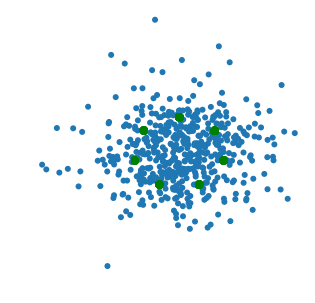

 10%|▉         | 1000/10001 [02:10<19:29,  7.70it/s]

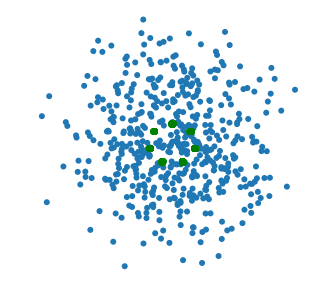

 20%|█▉        | 2000/10001 [04:21<17:14,  7.73it/s]

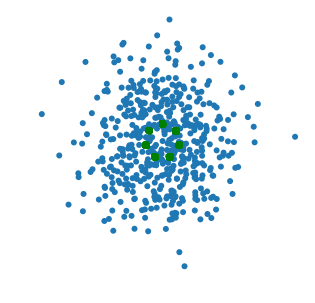

 30%|██▉       | 3000/10001 [06:30<14:54,  7.83it/s]

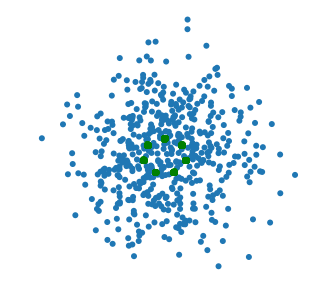

 40%|███▉      | 4000/10001 [08:41<12:24,  8.06it/s]

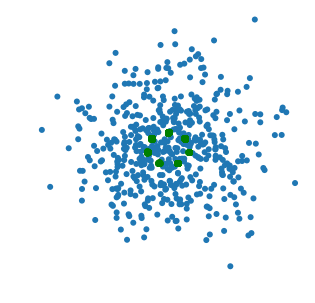

 50%|████▉     | 5000/10001 [10:51<10:47,  7.72it/s]

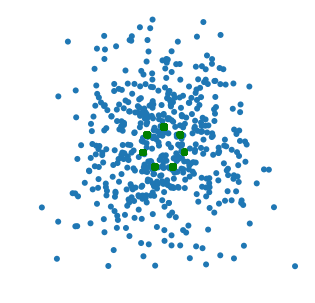

 60%|█████▉    | 6000/10001 [13:01<08:27,  7.88it/s]

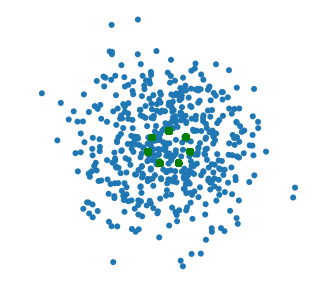

 70%|██████▉   | 7000/10001 [15:11<06:19,  7.91it/s]

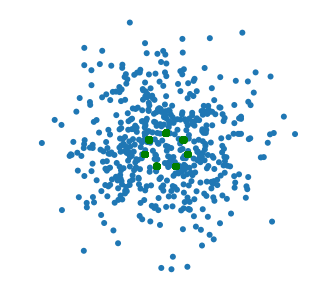

 80%|███████▉  | 8000/10001 [17:20<04:19,  7.73it/s]

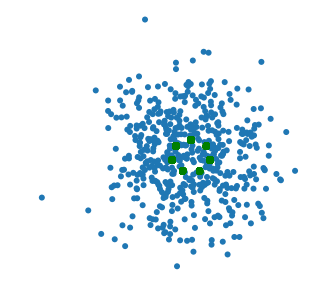

 90%|████████▉ | 9000/10001 [19:31<02:08,  7.78it/s]

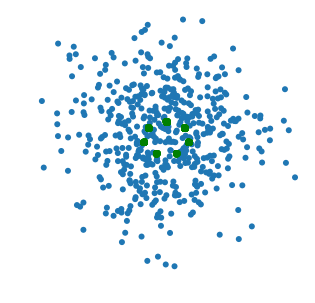

100%|█████████▉| 10000/10001 [21:40<00:00,  7.73it/s]

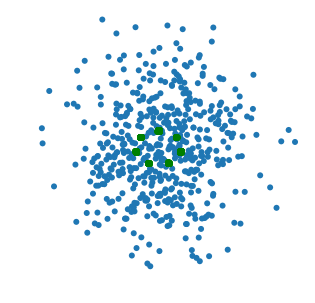

100%|██████████| 10001/10001 [21:41<00:00,  6.34it/s]


In [6]:
%pylab inline
np_samples = gan.train(epochs=10000, batch_size=512, sample_interval=1000, resume=0)

In [6]:
batch_size=512
minus = -np.ones((batch_size, 1), dtype=np.float32)
plus = np.ones((batch_size, 1), dtype=np.float32)
zero = np.zeros((batch_size, 1), dtype=np.float32)
X_train = tf.Session().run(sample_mog(60000))
idx = np.random.randint(0, X_train.shape[0], batch_size)
imgs = X_train[idx]
noise_1 = np.random.normal(0, 1, (batch_size, 256))
gen_imgs_1 = gan.generator.predict(noise_1, batch_size=batch_size)
noise_2 = np.random.normal(0, 1, (batch_size, 256))
gen_imgs_2 = gan.generator.predict(noise_2, batch_size=batch_size)
ε = np.random.uniform(size=(batch_size,1))
real_imgs = X_train[idx]
ave_imgs = ε * real_imgs + (1-ε) * gen_imgs_1

In [8]:
gan.critic_model.train_on_batch([gen_imgs_1, gen_imgs_2, real_imgs, ave_imgs],[minus, plus, plus, minus, zero])

[nan, -inf, inf, inf, -inf, inf]

In [9]:
gan.generator_model.train_on_batch([noise_1, noise_2, real_imgs],[plus, plus, minus])

[nan, inf, inf, -inf]

/home/k_yonhon/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/matplotlib/contour.py:1557: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/home/k_yonhon/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/matplotlib/contour.py:1558: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())
/home/k_yonhon/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/matplotlib/contour.py:1557: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/home/k_yonhon/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/matplotlib/contour.py:1558: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())
/home/k_yonhon/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/matplotlib/contour.py:1557: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/home/k_yonhon/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/matplotlib/contour.py:1558: UserWar

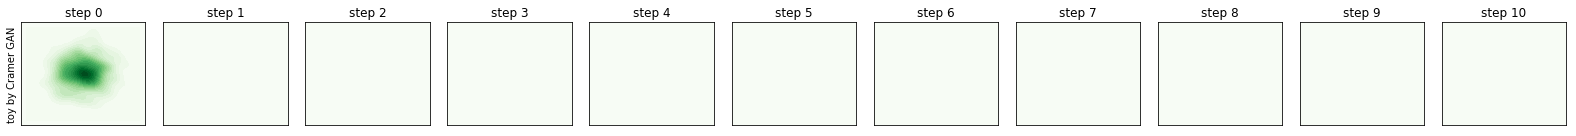

In [11]:
import seaborn as sns
np_samples_ = np_samples[::1]
cols = len(np_samples_)
bg_color  = sns.color_palette('Greens', n_colors=256)[0]
figure(figsize=(2*cols, 2))
for i, samps in enumerate(np_samples_):
    if i == 0:
        ax = subplot(1,cols,1)
    else:
        subplot(1,cols,i+1, sharex=ax, sharey=ax)
    ax2 = sns.kdeplot(samps[:, 0], samps[:, 1], shade=True, cmap='Greens', n_levels=20, clip=[[-3, 3]]*2)
    ax2.set_facecolor(bg_color)
    xticks([]); yticks([])
    title('step %d'%(i*1))
ax.set_ylabel('toy by Cramer GAN')
gcf().tight_layout()

In [12]:
noise = np.random.normal(0, 1, (10, 256))
gen_imgs = gan.generator.predict(noise)

In [13]:
gen_imgs

array([[nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan]], dtype=float32)

In [14]:
X_train = tf.Session().run(sample_mog(60000))
idx = np.random.randint(0, X_train.shape[0], 10)
imgs = X_train[idx]  

In [15]:
val = gan.critic(imgs)

ValueError: Layer model_5 was called with an input that isn't a symbolic tensor. Received type: <class 'numpy.ndarray'>. Full input: [array([[-0.78196719,  0.60541033],
       [-0.42874101, -0.89710004],
       [-0.02048183,  1.00462853],
       [-0.43737333, -0.89121597],
       [ 0.0019747 ,  0.98756655],
       [ 0.0052242 ,  1.00454816],
       [-0.43332323, -0.88992935],
       [-0.7739485 ,  0.61432576],
       [-0.41344219, -0.90180122],
       [ 0.43475328, -0.90262648]])]. All inputs to the layer should be tensors.